## Standard Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
import torch
import torch.nn as nn
import time
import math

## Loading Data

In [4]:
stocks = pd.read_csv("AAPL.csv",index_col=0,parse_dates=True)

In [5]:
stocks = stocks.drop(' Volume',axis = 1)
stocks = stocks[::-1]

In [6]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-03-01 to 2020-02-28
Data columns (total 4 columns):
 Close/Last    2518 non-null object
 Open          2518 non-null object
 High          2518 non-null object
 Low           2518 non-null object
dtypes: object(4)
memory usage: 98.4+ KB


In [7]:
stocks.head()

,Close/Last,Open,High,Low
Date,,,,
2010-03-01,$29.8557,$29.3928,$29.9286,$29.35
2010-03-02,$29.8357,$29.99,$30.1186,$29.6771
2010-03-03,$29.9043,$29.8486,$29.9814,$29.7057
2010-03-04,$30.1014,$29.8971,$30.1314,$29.8043
2010-03-05,$31.2786,$30.7057,$31.3857,$30.6614


In [8]:
stocks.tail()

,Close/Last,Open,High,Low
Date,,,,
2020-02-24,$298.18,$297.26,$304.18,$289.23
2020-02-25,$288.08,$300.95,$302.53,$286.13
2020-02-26,$292.65,$286.53,$297.88,$286.5
2020-02-27,$273.52,$281.1,$286,$272.96
2020-02-28,$273.36,$257.26,$278.41,$256.37


Converting $ into Float 

In [9]:
colums = stocks.columns

In [10]:
for i in colums:
    stocks[i]  = stocks[i].apply(lambda x : float(x.split('$')[1]))

In [11]:
stocks.head()

,Close/Last,Open,High,Low
Date,,,,
2010-03-01,29.8557,29.3928,29.9286,29.3500
2010-03-02,29.8357,29.9900,30.1186,29.6771
2010-03-03,29.9043,29.8486,29.9814,29.7057
2010-03-04,30.1014,29.8971,30.1314,29.8043
2010-03-05,31.2786,30.7057,31.3857,30.6614


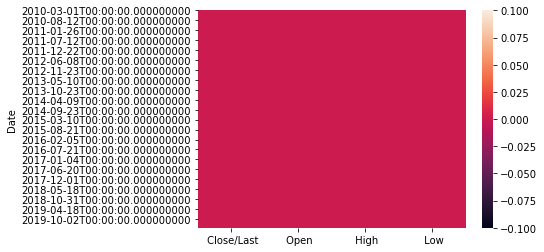

In [12]:
sns.heatmap(stocks.isnull())

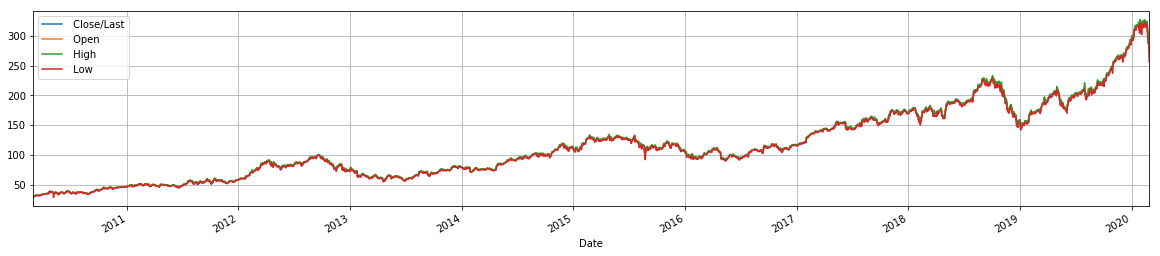

In [13]:
stocks.plot(figsize=(20,4),grid = True)

We can see that all the values are close to each other approximately.<br>
Therefore we'll only predict ***Close/Last*** values

In [14]:
stocks = stocks[[' Close/Last']]

In [15]:
stocks.head()

,Close/Last
Date,
2010-03-01,29.8557
2010-03-02,29.8357
2010-03-03,29.9043
2010-03-04,30.1014
2010-03-05,31.2786


In [16]:
stocks.tail()

,Close/Last
Date,
2020-02-24,298.18
2020-02-25,288.08
2020-02-26,292.65
2020-02-27,273.52
2020-02-28,273.36


## Test/Train Split

In [17]:
Y = stocks[' Close/Last'].values

In [18]:
test_size = 30
train_set = Y[:-test_size]

In [19]:
train_set

array([ 29.8557,  29.8357,  29.9043, ..., 316.96  , 312.68  , 311.34  ])

In [19]:
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [21]:
train_set = torch.FloatTensor(train_set.reshape(-1))

## Getting data ready for LSTM Model

In [22]:
def get_windows(data,ws):
    out = []
    L = len(data)
    for i in range(L-ws):
        out.append((data[i:i+ws],data[i+ws:i+ws+1]))
    return out

In [23]:
window_size = 30
train_data = get_windows(train_set,window_size)

## Defining Model,Optimizer and Loss Function

In [24]:
class LSTM(nn.Module):
    def __init__(self,in_size=1,hidden_size = 200,out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_size,hidden_size)
        self.hidden = (torch.zeros(1,1,hidden_size).cuda(),
                       torch.zeros(1,1,hidden_size).cuda())
        self.linear = nn.Linear(hidden_size,out_size)
    def forward(self,X):
        lstm_out,self.hidden = self.lstm(X.view(len(X),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(X),-1))
        return pred[-1]

In [25]:
model = LSTM().cuda()

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

## Training Model to predict a part of Training Data

In [27]:
import time
import math
start = time.time()
epochs = 100
for i in range(epochs):
    for X_train,Y_train in train_data:
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
        Y_pred = model(X_train)
        loss = criterion(Y_pred,Y_train)
        loss.backward()
        optimizer.step()
    if(i==0 or (i+1)%10 == 0):
        print(f'Epoch : {i+1} LOSS : {loss.item():.10f}')
end = time.time()
dur = end-start
print(f"Train Duration : {math.floor(dur/60)} minutes {math.ceil(dur%60)} seconds !!")

Epoch : 1 LOSS : 5488.0478515625
Epoch : 10 LOSS : 8907.9824218750
Epoch : 20 LOSS : 7500.9433593750
Epoch : 30 LOSS : 1775.8374023438
Epoch : 40 LOSS : 6.8544635773
Epoch : 50 LOSS : 13.5668392181
Epoch : 60 LOSS : 10.7900457382
Epoch : 70 LOSS : 5.9880633354
Epoch : 80 LOSS : 36.5222663879
Epoch : 90 LOSS : 19.3379306793
Epoch : 100 LOSS : 11.5647315979
Train Duration : 58 minutes 35 seconds !!


In [28]:
preds = train_set[-window_size:].tolist()
model.eval()
for i in range(window_size):
    X_test = torch.FloatTensor(preds[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),
                        torch.zeros(1,1,model.hidden_size).cuda())
        preds.append(model(X_test).item())

In [36]:
predictions = preds[-window_size:]
print(predictions,Y[-window_size:])

[313.70953369140625, 313.3833312988281, 313.5502014160156, 313.4690856933594, 313.5095520019531, 313.4913330078125, 313.5029296875, 313.5008239746094, 313.5069274902344, 313.5098571777344, 313.5188293457031, 313.5229797363281, 313.54278564453125, 313.54156494140625, 313.57403564453125, 313.5619812011719, 313.5966491699219, 313.58087158203125, 313.6039123535156, 313.5846862792969, 313.6078186035156, 313.5955505371094, 313.5997619628906, 313.58953857421875, 313.575927734375, 313.5874938964844, 313.5563659667969, 313.59197998046875, 313.5816650390625, 313.5755615234375] [315.24 318.73 316.57 317.7  319.23 318.31 308.95 317.69 324.34 323.87
 309.51 308.66 318.85 321.45 325.21 320.03 321.55 319.61 327.2  324.87
 324.95 319.   323.62 320.3  313.05 298.18 288.08 292.65 273.52 273.36]


In [29]:
len(preds)

60

In [30]:
dates = stocks.index

In [31]:
desired_dates = (dates[-window_size:])

In [32]:
train_dates = np.array(desired_dates,dtype = 'datetime64[D]')

In [33]:
train_dates

array(['2020-01-16', '2020-01-17', '2020-01-21', '2020-01-22',
       '2020-01-23', '2020-01-24', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-03',
       '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-18', '2020-02-19', '2020-02-20',
       '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
       '2020-02-27', '2020-02-28'], dtype='datetime64[D]')

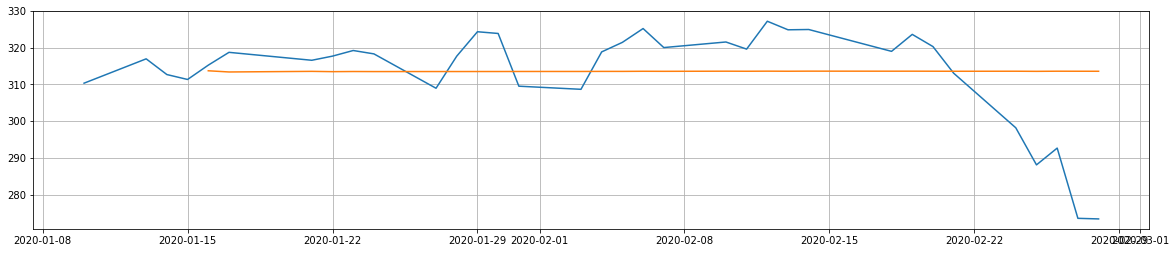

In [39]:
plt.figure(figsize=(20,4))
plt.grid(True)
plt.plot(stocks[' Close/Last']['2020-01-10':])
plt.plot(train_dates,predictions)

Needs more training<br>At least 500-1000 Epochs

## Saving the model

In [40]:
torch.save(model.state_dict(),"./partial_model.pt")